# Workshop: Introducción a Generative AI en Oracle y Creación de Agentes con LangChain

Bienvenidos al workshop. En esta sesión vamos a explorar cómo usar los **servicios de IA generativa de Oracle** para resolver problemas reales y luego **crear un agente inteligente** usando **LangChain** que pueda interactuar con estos servicios.

## Objetivos de la sesión
- Conocer la oferta de **Oracle Cloud Infrastructure (OCI Generative AI)** y cómo integrarla desde Python.
- Ejecutar peticiones a modelos de lenguaje para **generar texto** de manera controlada.
- Construir un **agente con LangChain** que use herramientas (como SQL o RAG) para responder preguntas de forma autónoma.
- Aprender buenas prácticas para **orquestar flujos de trabajo** y extender capacidades de los modelos.

## Requisitos previos
- Conocimientos básicos de Python 🐍
- Tener acceso a una cuenta de **Oracle Cloud** con permisos para usar **OCI Generative AI**
- Familiaridad básica con entornos virtuales y Jupyter Notebooks.

> 💡 **Tip:** este notebook está diseñado para ser práctico y paso a paso. Podrás copiar, ejecutar y modificar el código para experimentar con los conceptos que vamos a explicar.

¡Vamos a empezar!

## A continuación... 

📰 Recopilaremos noticias sobre Innovación y tecnología chilena

🤖 Consumiremos un modelo de lenguaje alojado en Oracle Cloud 

🔍 Construiremos un agente con langchain que es capaz de responder a preguntas relacionadas con las StartUps, tecnología, IA y futuro digital en Chile.

## Instalación

In [ ]:
!pip install -U langchain==0.3.20 langchain-oci==0.1.6 tavily-python oci


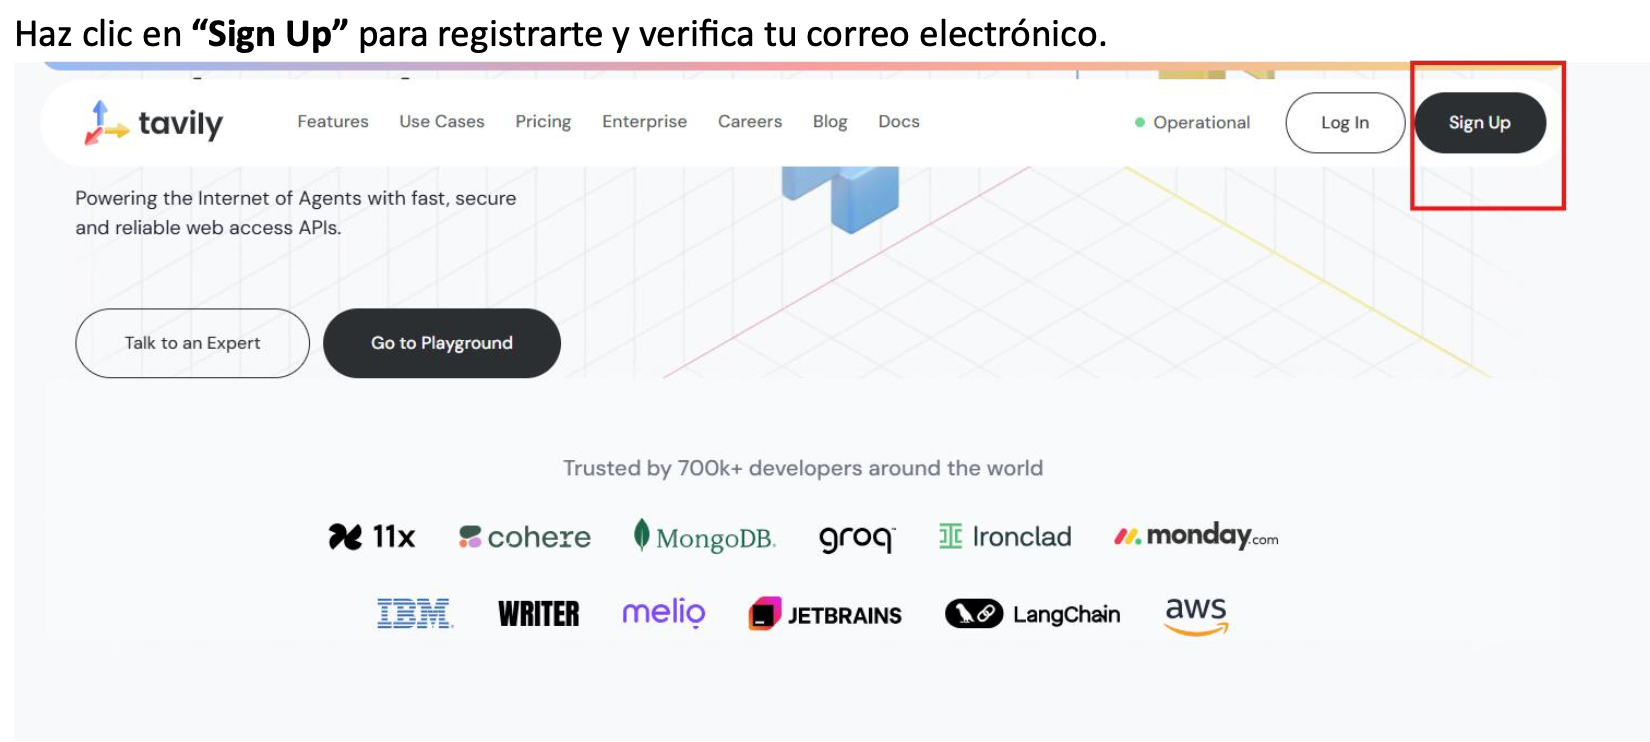


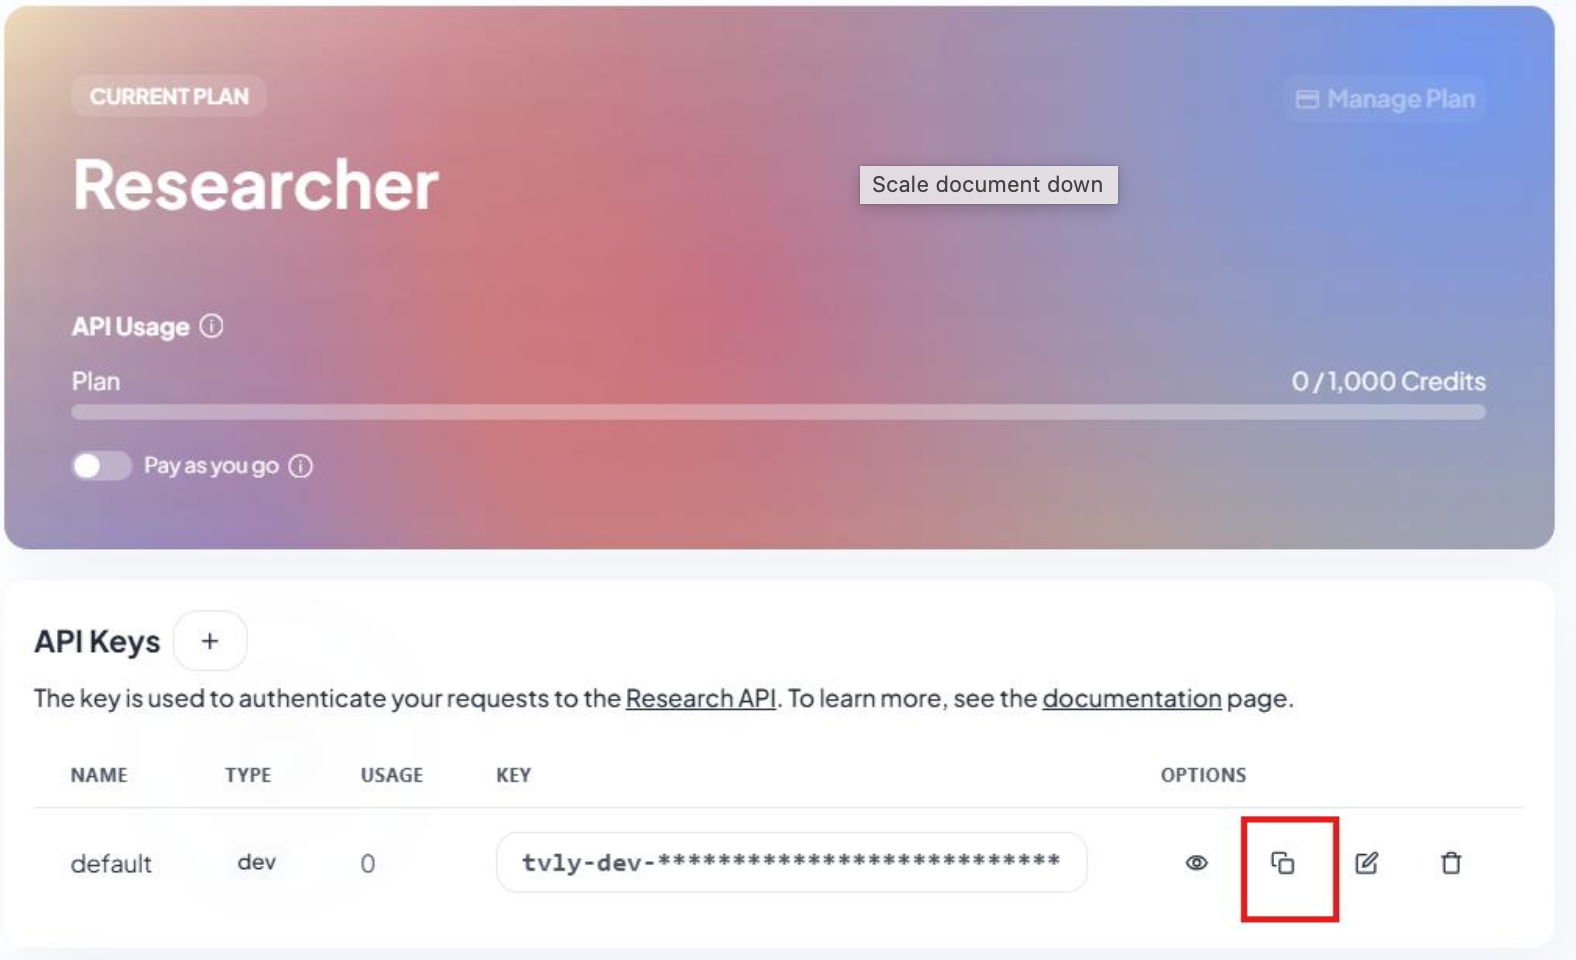

In [1]:
import base64, pathlib
from IPython.display import HTML, display

def embed_png(path, width=520):
    data = base64.b64encode(pathlib.Path(path).read_bytes()).decode("ascii")
    return HTML(f'<img src="data:image/png;base64,{data}" width="{width}">')

display(HTML("<h3>🪪 Registro en Tavily (paso a paso)</h3>"))
display(HTML("<p>1️⃣ Abre <a href='https://app.tavily.com/home' target='_blank'>https://app.tavily.com/home</a> y haz clic en <b>Sign Up</b>.</p>"))
display(embed_png("images/tavily_signup.png"))
display(HTML("<p>2️⃣ Inicia sesión y copia tu <b>API Key</b> desde la página principal.</p>"))
display(embed_png("images/api_key.png"))

In [ ]:
# Pega la API Key de Tavily aquí
TAVILY_API_KEY = "pega_aqui_tu_api_key"

In [ ]:
assert TAVILY_API_KEY != "pega_aqui_tu_api_key", "Por favor, pega tu API Key de Tavily en la variable TAVILY_API_KEY"

## Configuración de la autenticación del SDK de OCI

Desde este notebook es necesario acceder a algunos servicios de Oracle, como el servicio de Generative AI, aunque ejecutes este notebook en cloud o de forma local, es necesario configurar las credenciales en la máquina que realiza el consumo del servicio. 

```
En los pasos anteriores fue necesario descargar un archivo terminado en .pem y copiar una configuración con el siguiente estilo
[DEFAULT]
user=ocid1.user.oc1..
fingerprint=95:e1:09
tenancy=ocid1.tenancy.oc1..
region= 
```

A continuación usaremos esos objetos.

In [ ]:
# crea carpeta y permisos
!mkdir -p /home/datascience/.oci

In [ ]:
!mkdir -p ~/.oci
!ls -la ~/.oci

Ahora vamos a ubicar la llave privada que descargamos en los pasos anteriores al generar el API Key. El archivo tendrá un nombre similar a “tu_usuario-año-mes-diaTHH_MM_SS.XXX.pem”.

Este archivo debe renombrarse como “oci_api_key.pem” y cargarse en Data Science utilizando la opción “Upload Files”, o bien arrastrándolo directamente en el menú izquierdo del navegador.

Una vez que el archivo esté cargado, podremos proceder con la ejecución de la siguiente línea.

In [ ]:
!mv ~/oci_api_key.pem ~/.oci/oci_api_key.pem
!chmod 600 ~/.oci/oci_api_key.pem
!ls -la ~/.oci

A continuación, crearemos el archivo de configuración en la ruta ~/.oci/config, vamos a copiar los valores de la configuración mostrada en pantalla y a reemplazarlos en la siguiente línea.

Reemplazaremos _ocid1.user.oc1.._ por el ocid del usuario mostrado en pantalla
Reemplazaremos _fingerprint_ por el figerprint mostrado en pantalla
🚨 No reemplazaremos _key_file_ por ninguna ruta si estamos ejecutando este notebook en DataScience. Si queremos ejecutar este notebook de forma local, podemos reemplazar la ruta por ~/.oci/nombre_de_la_key.pem

In [ ]:
%%bash
cat > ~/.oci/config <<'CFG'

[DEFAULT]
user=ocid1.user.oc1..aaaaaaaa... # coloca aqui el OCID de tu usuario
fingerprint=ab:50:7a:...:d4:5f # coloca aqui el fingerprint de tu clave API
tenancy=ocid1.tenancy.oc1..aaaaaaaa... # coloca aqui el OCID de tu tenancy
region=us-chicago-1
key_file=/home/datascience/.oci/oci_api_key.pem
CFG

echo "Config creado en ~/.oci/config"
cat ~/.oci/config | sed 's/fingerprint=.*/fingerprint=<oculto>/'

In [ ]:
# Descomenta únicamente la línea que corresponda a tu región
#REGION = "sa-saopaulo-1"
REGION = "us-chicago-1"
#REGION = "uk-london-1"
#REGION = "eu-frankfurt-1"
#REGION = "ap-osaka-1"

## 🤖 Creación del Agente LangChain

In [ ]:
# CONFIGURACIÓN DEL AGENTE LANGCHAIN + LLAMA 4
from langchain_oci import ChatOCIGenAI
from langchain.agents import create_react_agent, AgentExecutor
from langchain_core.prompts import PromptTemplate
from langchain_core.tools import tool
from tavily import TavilyClient

# Compartment ID en OCI ---
COMPARTMENT_ID = "ocid1.compartment.oc1..aaaaaa..." #coloca aqui tu compartment OCID

# ID del modelo (Llama 4 Maverick)
MODEL_ID = "ocid1.generativeaimodel.oc1.us-chicago-1.amaaaaaask7dceyayjawvuonfkw2ua4bob4rlnnlhs522pafbglivtwlfzta" #Llama 4 Maverick
#MODEL_ID = "ocid1.generativeaimodel.oc1.us-chicago-1.amaaaaaask7dceyarojgfh6msa452vziycwfymle5gxdvpwwxzara53topmq" #Llama 4 Scout

# Inicializamos el LLM
llm = ChatOCIGenAI(
    model_id=MODEL_ID,
    service_endpoint=f"https://inference.generativeai.{REGION}.oci.oraclecloud.com",
    compartment_id=COMPARTMENT_ID,
    provider="meta",
    model_kwargs={
        "temperature": 0.3,
        "max_tokens": 800,
        "top_p": 0.8
    },
    auth_type="API_KEY",
    auth_profile="DEFAULT"
)

# Creamos una herramienta
@tool
def get_chilean_innovation_news(pregunta: str) -> str:
    """Busca información sobre innovación, ciencia y tecnología en Chile."""
    client = TavilyClient(TAVILY_API_KEY)
    try:
        response = client.search(query=query, max_results=5)
        results = response.get("results", [])
        formatted = "\n".join([f"- **{r['title']}** ({r['url']})" for r in results])
        return formatted if formatted else "No se encontraron resultados relevantes."
    except Exception as e:
        return f"Error en la búsqueda: {e}"

tools = [get_chilean_innovation_news]

# Plantilla ReAct
react_prompt_template = """Eres un experto en **innovación y tecnología chilena**.
Usa las herramientas cuando aporten valor.
Responde en español neutro y con un tono profesional y actualizado.

Herramientas disponibles:
{tools}

Formato:
Question: la pregunta
Thought: qué vas a hacer
Action: una de [{tool_names}]
Action Input: el input
Observation: resultado
Thought: analiza y sintetiza
Final Answer: respuesta clara y útil.

Empecemos.
Question: {input}
Thought:{agent_scratchpad}
"""

prompt = PromptTemplate.from_template(react_prompt_template)

# Construcción del agente
agent = create_react_agent(llm, tools, prompt)

agent_executor = AgentExecutor(
    agent=agent,
    tools=tools,
    verbose=True,
    handle_parsing_errors=True
)

# Pregunta al agente
pregunta = "¿Qué startups chilenas están aplicando inteligencia artificial o tecnologías sostenibles en 2025?"
respuesta = agent_executor.invoke({"input": pregunta})

print("\n--- RESPUESTA DEL AGENTE ---\n")
print(respuesta["output"])

In [ ]:
from langchain_oci import ChatOCIGenAI
from langchain.agents import create_react_agent, AgentExecutor
from langchain_core.prompts import PromptTemplate
from langchain_core.tools import tool
from langchain_core.messages import HumanMessage
from IPython.display import Markdown, display
import json

# Configuración de OCI
COMPARTMENT_ID = "ocid1.compartment.oc1..aaa..." #coloca aqui tu compartment OCID

MODEL_ID_LLAMA = "ocid1.generativeaimodel.oc1.us-chicago-1.amaaaaaask7dceyayjawvuonfkw2ua4bob4rlnnlhs522pafbglivtwlfzta" #Llama 4 Maverick


# === LLM principal ===
llm = ChatOCIGenAI(
    model_id=MODEL_ID_LLAMA,
    service_endpoint=f"https://inference.generativeai.{REGION}.oci.oraclecloud.com",
    compartment_id=COMPARTMENT_ID,
    provider="meta",
    model_kwargs={"temperature": 0.3, "max_tokens": 800, "top_p": 0.8},
    auth_type="API_KEY",
    auth_profile="DEFAULT"
)

# Herramienta
@tool
def get_chilean_innovation_news(pregunta: str) -> str:
    """Busca información sobre innovación, ciencia y tecnología en Chile."""
    try:
        client = TavilyClient(api_key=TAVILY_API_KEY)
        response = client.search(query=query, max_results=5)
        results = response.get("results", [])
        if not results:
            return "No se encontraron resultados relevantes."
        formatted = "\n".join([f"- **{r['title']}** ({r['url']})" for r in results])
        return formatted
    except Exception as e:
        return f"⚠️ Error al realizar la búsqueda: {e}"

tools = [get_chilean_innovation_news]

# Prompt del agente ReAct
react_prompt_template = """Eres un experto en innovación, ciencia y tecnología chilena.
Usa las herramientas cuando sea necesario. Responde en español neutro, tono profesional.

Herramientas disponibles:
{tools}

Formato EXACTO:
Question: la pregunta
Thought: qué vas a hacer
Action: una de [{tool_names}]
Action Input: el input
Observation: resultado
Thought: analiza y sintetiza
Final Answer: respuesta clara y útil.

Empecemos.
Question: {input}
Thought:{agent_scratchpad}
"""

prompt = PromptTemplate.from_template(react_prompt_template)

# Construcción del agente
agent = create_react_agent(llm, tools, prompt)
agent_executor = AgentExecutor(agent=agent, tools=tools, verbose=True, handle_parsing_errors=True)

# Ejecución del agente
pregunta = "¿Qué startups chilenas están aplicando inteligencia artificial o tecnologías sostenibles en 2025?"
#pregunta = "¿Cuáles son las últimas tendencias en innovación tecnológica en Chile?"
#pregunta = "Dime qué es Open StartUp Fest de la UAI."
#pregunta = "¿Qué impacto ha tenido la pandemia en la innovación en Chile?"
respuesta = agent_executor.invoke({"input": pregunta})
texto_base = respuesta["output"]

# Post-procesamiento con formato Markdown
analysis_prompt = f"""
Convierte el siguiente texto en una respuesta en **formato Markdown profesional**:

TEXTO:
{texto_base}

Debes estructurarlo así:

## 🧠 Resumen general
Breve descripción en 3–5 líneas.

## 🚀 Startups chilenas destacadas
Lista de empresas, sector y tecnología (en bullets).

## 🌱 Tecnologías o tendencias clave
Breve análisis sobre innovación, IA o sostenibilidad.

## 🔍 Conclusión
Resumen final con enfoque estratégico o impacto país.

Formato Markdown claro, limpio y con íconos donde apliquen.
"""

# Llama 4 vuelve a dar formato
formatted = llm.invoke([HumanMessage(content=analysis_prompt)])

display(Markdown(formatted.content))